## Code by Tranchant et al.2025, with modifications

In [29]:
import sys
import xarray as xr
import matplotlib.pyplot as plt
from MyProject import functions
from scipy.signal import butter, filtfilt

sys.path.append('../')

In [31]:
from SwotDiag.diagnosis import *

### Standard SWOT product (2 km, L3)

In [38]:
swot = xr.open_dataset('MyProject/calval_pass20_all_cycles_zoom.nc')
# swot = xr.open_dataset('Coding/sub-data-science-phase/science_pass_cycle_46.nc')
# swot = xr.open_dataset('Coding/KaRin_nadir_data_line.nc')

start = np.datetime64("2023-04-07")
end = np.datetime64("2023-07-10")

# start = np.datetime64("2023-09-10")
# end = np.datetime64("2024-09-30")

swot = swot.where((swot.time >= start) & (swot.time <= end), drop=True)

In [40]:
# lon = ((swot.longitude + 180 )% 360) - 180
# lon

/var/folders/7d/76c27lb97m18k6jd1mcn12yc0000gn/T/ipykernel_75275/1488126010.py:5: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(swot.longitude, swot.latitude, swot.mdt, cmap = 'RdBu_r')


<Figure size 500x500 with 0 Axes>

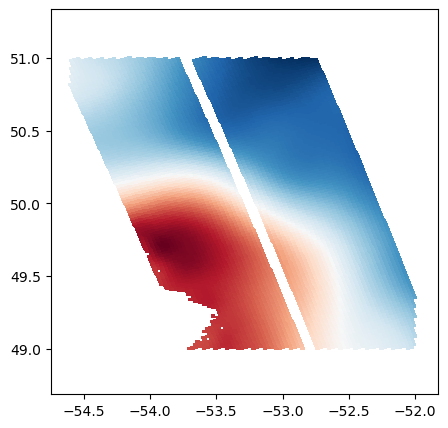

In [42]:
plt.figure(figsize = (5,5))

plt.figure(figsize = (5,5))

plt.pcolormesh(swot.longitude, swot.latitude, swot.mdt, cmap = 'RdBu_r')

# plt.scatter(-55.162333, 53.491)
# plt.scatter(-55.0333, 53.53333)

#### General utilization

In [45]:
params = dict(derivative = 'fit', # Derivative obtained by the fitting method instead of point difference
          n = 5, # 13*13 point kernels
          min_valid_points = 0.75, # Ratio of valid points to compute the derivative (e.g. 75% valid points are necessary to compute the derivatives, useful to avoid boundary effects)
          cyclostrophy = 'GW', # Cyclogeostrophic currents are computed using the wind-gradient balance
          avoid_negative = False, # Parameter that avoid negative values in the SQRT using the GW formulation (leading to invalid values in the solutions)
          second_derivative = 'dxdy', # The second derivative is obtained by point-difference the first derivative (obtained by surface fitting method), rather than from the surface curvature. I noticed that it reduces the noise. 
          kernel = 'circular', # can be circular or a square, the shape of the kernel

)

## Diagnostics from original SSH
diag = compute_ocean_diagnostics_from_eta(swot.ssha_filtered + swot.mdt, swot.longitude, swot.latitude, **params)

Fitting derivatives on 844284 points (5*5 points kernel): 100%|██████████| 12236/12236 [00:03<00:00, 3278.72it/s]
/Users/dihyachaal/Desktop/SwotDiag/diagnosis.py:176: RuntimeWarning: invalid value encountered in sqrt
  ucg = 2*ug/(1+np.sqrt(c))
/Users/dihyachaal/Desktop/SwotDiag/diagnosis.py:177: RuntimeWarning: invalid value encountered in sqrt
  vcg = 2*vg/(1+np.sqrt(c))


In [47]:
### Adding the computed diagnostics to the original xarray dataset

dims = swot.ugos_filtered.dims
swot = swot.assign(ugos_csiro = (dims, diag['ug']), vgos_csiro = (dims, diag['vg']), 
                   ucgos_csiro = (dims, diag['ucg']), vcgos_csiro = (dims, diag['vcg']),
                  zeta_csiro = (dims, diag['zeta']), sr_csiro = (dims, diag['S']), OW_csiro = (dims, diag['OW']))

/var/folders/7d/76c27lb97m18k6jd1mcn12yc0000gn/T/ipykernel_75275/4008029745.py:7: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(swot.longitude, swot.latitude, Ug)
/var/folders/7d/76c27lb97m18k6jd1mcn12yc0000gn/T/ipykernel_75275/4008029745.py:13: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(swot.longitude, swot.latitude, Ucg - Ug, cmap = 'RdBu_r')
/var/folders/7d/76c27lb97m18k6jd1mcn12yc0000gn/T/ipykernel_75275/4008029745.py:18: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or dec

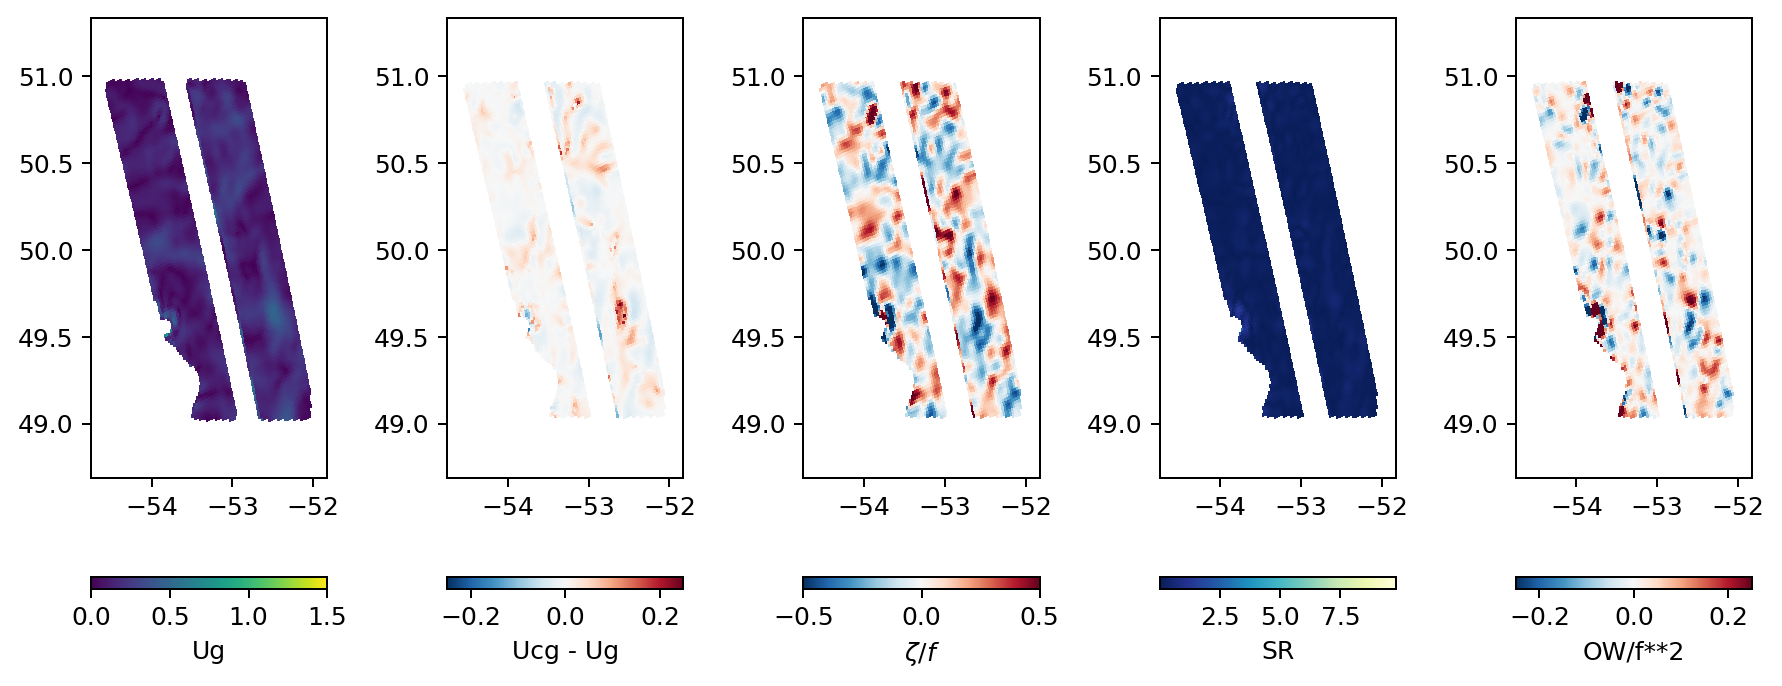

In [49]:
Ug = np.sqrt(swot.ugos_csiro**2 + swot.vgos_csiro**2)
Ucg = np.sqrt(swot.ucgos_csiro**2 + swot.vcgos_csiro**2)

plt.figure(figsize = (10,4), dpi = 180)

plt.subplot(151)
plt.pcolormesh(swot.longitude, swot.latitude, Ug)
# plt.scatter(lon_mooring1,lat_mooring1)
plt.colorbar(orientation = 'horizontal', label = r'Ug')
plt.clim(0,1.5)

plt.subplot(152)
plt.pcolormesh(swot.longitude, swot.latitude, Ucg - Ug, cmap = 'RdBu_r')
plt.colorbar(orientation = 'horizontal', label = r'Ucg - Ug')
plt.clim(-0.25,0.25)

plt.subplot(153)
plt.pcolormesh(swot.longitude, swot.latitude, swot.zeta_csiro, cmap = 'RdBu_r')
plt.colorbar(orientation = 'horizontal', label = r'$\zeta/f$')
plt.clim(-0.5,0.5)

plt.subplot(154)
plt.pcolormesh(swot.longitude, swot.latitude, swot.sr_csiro, cmap = 'YlGnBu_r')
plt.colorbar(orientation = 'horizontal', label = 'SR')
# plt.clim(0,0.5)

plt.subplot(155)
plt.pcolormesh(swot.longitude, swot.latitude, swot.OW_csiro, cmap = 'RdBu_r')
plt.colorbar(orientation = 'horizontal', label = 'OW/f**2')
plt.clim(-0.25,0.25)

plt.tight_layout()

## Compare the computed velocities to SWOT and mooring velocities

In [52]:
ugos_csiro = swot.ugos_csiro.values
ugos_filtered = swot.ugos_filtered.values
vgos_csiro = swot.vgos_csiro.values
vgos_filtered = swot.vgos_filtered.values


valid_mask = ~np.isnan(ugos_csiro) & ~np.isnan(ugos_filtered)

ugos_csiro_valid = ugos_csiro[valid_mask]
vgos_csiro_valid = vgos_csiro[valid_mask]
ugos_filtered_valid = ugos_filtered[valid_mask]
vgos_filtered_valid = vgos_filtered[valid_mask]

u_fk = np.sqrt(ugos_csiro_valid**2 + vgos_csiro_valid**2)

u_swot =  np.sqrt(ugos_filtered_valid**2 +  vgos_filtered_valid**2)

corr_u = np.abs(np.corrcoef(u_fk, u_swot)[0, 1])
rmse_u = np.sqrt(np.mean((u_swot - u_fk) ** 2))

print(f"correlation: {corr_u}")
print(f"rmse: {rmse_u}")

correlation: 0.9707549593372312
rmse: 0.04089494336224231


In [54]:
# RMSD = [0.0358, 0.0459, 0.0561, 0.0624, 0.0681, 0.07227, 0.0763, 0.0825]
# corr = [0.9815, 0.9695, 0.9528, 0.9398, 0.9274, 0.9186, 0.9094, 0.8939]

In [110]:
lon_mooring1 = -53.00083
lat_mooring1 = 50.74967

lon_mooring2 = -53.264167
lat_mooring2 = 50.164667

lon_mooring3 = -52.584277
lat_mooring3 = 49.749922

lon_LCC1 = -55.56367
lat_LCC1 = 53.37517

lon_LCC3 = -55.162333
lat_LCC3 =  53.491

lon_LCC4 = -55.0333
lat_LCC4 =  53.53333

radius = 10 #km
dist = functions.haversine_distance(swot.latitude, swot.longitude, lat_mooring3, lon_mooring3)
mask = dist < radius
ugeos_mooring = swot.ugos_csiro.where(mask, drop=True)
vgeos_mooring = swot.vgos_csiro.where(mask, drop=True)
ssha_mooring = swot.ssha_filtered.where(mask, drop=True)
mdt_mooring = swot.mdt.where(mask, drop=True)
ssh = ssha_mooring + mdt_mooring

time = swot.time.where(mask, drop=True)

In [112]:
u_geo_mean = np.nanmean(ugeos_mooring, axis=1)
v_geo_mean = np.nanmean(vgeos_mooring, axis=1)
time_dt = pd.to_datetime(time[:, 0])

df_swot_u = pd.DataFrame({
    'time': pd.to_datetime(time_dt),
    'u_total': u_geo_mean  
})
daily = df_swot_u.groupby(df_swot_u['time'].dt.date)
daily_mean = daily['u_total'].mean()
daily_time = daily['time'].apply(lambda x: x.iloc[0]) 

df_swot_u = pd.DataFrame({
    'time': daily_time.values,
    'u_total_mean': daily_mean.values
}).set_index('time')


df_swot_v = pd.DataFrame({
    'time': pd.to_datetime(time_dt),
    'v_total': v_geo_mean 
})

daily_v = df_swot_v.groupby(df_swot_v['time'].dt.date)
daily_mean_v = daily_v['v_total'].mean()

df_swot_v = pd.DataFrame({
    'time': daily_time.values,
    'v_total_mean': daily_mean_v.values
}).set_index('time')


df_interp_swot_u = df_swot_u.interpolate(method='linear')
filtered_swot_u = functions.butter_filter_velocity(df_interp_swot_u.index, df_interp_swot_u['u_total_mean'])
df_interp_swot_v = df_swot_v.interpolate(method='linear')
filtered_swot_v = functions.butter_filter_velocity(df_interp_swot_v.index, df_interp_swot_v['v_total_mean'])

/var/folders/7d/76c27lb97m18k6jd1mcn12yc0000gn/T/ipykernel_75275/2830603260.py:1: RuntimeWarning: Mean of empty slice
  u_geo_mean = np.nanmean(ugeos_mooring, axis=1)
/var/folders/7d/76c27lb97m18k6jd1mcn12yc0000gn/T/ipykernel_75275/2830603260.py:2: RuntimeWarning: Mean of empty slice
  v_geo_mean = np.nanmean(vgeos_mooring, axis=1)


In [122]:
# output_df = pd.DataFrame({'time': df_swot_u.index, 
#                           'ugeos': df_swot_u['u_total_mean'], 'vgeos':df_swot_v['v_total_mean']})
# output_df = output_df.iloc[1:]
# output_df.to_csv('swot_ugos_201_LCC3.csv', index=False)

In [124]:
swot_data = pd.read_csv('MyProject/swot_ugos_3_final.csv')
swot_data['time'] = pd.to_datetime(swot_data['time'])

In [126]:
swot_data['time']

0    2023-04-07 12:59:07.530728064
1    2023-04-08 12:49:45.709951744
2    2023-04-09 12:40:23.858779392
3    2023-04-10 12:31:01.971121920
4    2023-04-11 12:21:40.049531520
                  ...             
86   2023-07-05 22:55:55.394285056
87   2023-07-06 22:46:33.310754176
88   2023-07-07 22:37:11.198981632
89   2023-07-08 22:27:49.062692736
90   2023-07-09 22:18:26.902249088
Name: time, Length: 91, dtype: datetime64[ns]

In [128]:
dm = xr.open_dataset('MyProject/Mooring_data_CalVal/SWOT3_01.nc')
time_m = dm['TIME'].values
start = np.datetime64("2023-04-07")
end = np.datetime64("2023-07-10")
dm = dm.where((dm.DEPTH <= -10), drop=True)
dm_FS = dm.where((dm.TIME >= start) & (dm.TIME <= end), drop=True)
velocity_east = dm_FS['velocity_east'].values
velocity_north = dm_FS['velocity_north'].values
depth = dm_FS['DEPTH'].values
depth_mask = (depth >= -65) & (depth <= -30)
u_layer = dm_FS.velocity_east.sel(DEPTH=depth_mask)
v_layer = dm_FS.velocity_north.sel(DEPTH=depth_mask)

In [132]:
# LCC3_data = pd.read_csv('coding/swot_ugos_LCC3_final.csv')
# LCC3_data['time'] = pd.to_datetime(LCC3_data.time)
# u_LCC3 = LCC3_data.filtered_u
# v_LCC3 = LCC3_data.filtered_v

def find_nearest_index(time, target_time):
    return np.argmin(np.abs(time - target_time))

satellite_time = np.array(df_swot_u.index) 
time_indices = [find_nearest_index(dm_FS.TIME.values, sat_time) for sat_time in satellite_time]

np.shape(time_indices)

(91,)

In [134]:
dm_u_layer = pd.DataFrame({'Time':dm_FS.TIME, 'Value': np.nanmean(u_layer, axis=1)})
dm_u_layer = dm_u_layer.set_index('Time')
dm_u_layer = dm_u_layer.resample('1h').mean()
filtered_u_layer = functions.filter_velocity(dm_u_layer['Value'])

dm_v_layer = pd.DataFrame({'Time':dm_FS.TIME, 'Value': np.nanmean(v_layer, axis=1)})
dm_v_layer = dm_v_layer.set_index('Time')
dm_v_layer = dm_v_layer.resample('1h').mean()
filtered_v_layer = functions.filter_velocity(dm_v_layer['Value'])

In [138]:
corr_u = np.abs(np.corrcoef(filtered_u_layer[time_indices], filtered_swot_u)[0,1])
rmse_u = np.sqrt(np.mean((filtered_u_layer[time_indices]-filtered_swot_u)**2)) 
print(f"correlation:", corr_u)
print(f"rmse:", rmse_u) 
corr_v = np.abs(np.corrcoef(filtered_v_layer[time_indices], filtered_swot_v)[0,1])
rmse_v = np.sqrt(np.mean((filtered_v_layer[time_indices]-filtered_swot_v)**2)) 
print(f"correlation:", corr_v)
print(f"rmse:", rmse_v) 

correlation: 0.7735902827420779
rmse: 0.08876677166350846
correlation: 0.6793972247477869
rmse: 0.10506785708172536


In [140]:
u_fk = np.sqrt(filtered_swot_u**2 + filtered_swot_v**2)
u_mooring = np.sqrt(filtered_u_layer[time_indices]**2 + filtered_v_layer[time_indices]**2)
u_swot =  np.sqrt(swot_data.filtered_u**2 +  swot_data.filtered_v**2)
# u_fk = np.sqrt(df_interp_swot_u['Value']**2 + df_interp_swot_v['Value']**2)
# u_swot = np.sqrt(swot_data.filtered_u**2 + swot_data.filtered_v**2)

corr = np.abs(np.corrcoef(u_fk, u_mooring))[0,1]
rmse = np.sqrt(np.mean((np.array(u_mooring) - np.array(u_fk))**2)) 
print(f"correlation:", corr)
print(f"rmse:", rmse) 

correlation: 0.5809216082903994
rmse: 0.10699954129510807


Text(0.01, 0.93, '(b)')

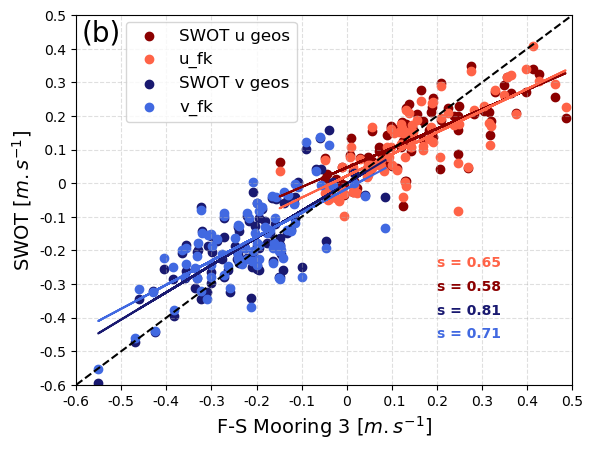

In [142]:
plt.scatter(filtered_u_layer[time_indices], swot_data.filtered_u, c='darkred', label='SWOT u geos')
plt.scatter(filtered_u_layer[time_indices], filtered_swot_u, c='tomato', label='u_fk')
plt.scatter(filtered_v_layer[time_indices], swot_data.filtered_v, marker='o', c='midnightblue', label='SWOT v geos')
plt.scatter(filtered_v_layer[time_indices], filtered_swot_v, marker='o', c='royalblue', label='v_fk')
plt.grid(linestyle='--',alpha=0.4)

a, b = np.polyfit(filtered_u_layer[time_indices], swot_data.filtered_u, 1)
c, d = np.polyfit(filtered_u_layer[time_indices],filtered_swot_u, 1)
e, f = np.polyfit(filtered_v_layer[time_indices], swot_data.filtered_v, 1)
i, j = np.polyfit(filtered_v_layer[time_indices],filtered_swot_v, 1)

#adding linear regression line to scatterplot 
plt.plot(filtered_u_layer[time_indices], a*filtered_u_layer[time_indices]+b, c='darkred');
plt.plot(filtered_u_layer[time_indices], c*filtered_u_layer[time_indices]+d, c='tomato');
plt.plot(filtered_v_layer[time_indices], e*filtered_v_layer[time_indices]+f, c='midnightblue');
plt.plot(filtered_v_layer[time_indices], i*filtered_v_layer[time_indices]+j, c='royalblue')

plt.xticks([-0.6, -0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3,0.4, 0.5], ['-0.6','-0.5', '-0.4', '-0.3', '-0.2', '-0.1', '0', ' 0.1', '0.2', '0.3','0.4','0.5'])
plt.yticks([-0.6, -0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5], ['-0.6','-0.5', '-0.4', '-0.3', '-0.2', '-0.1', '0', ' 0.1', '0.2', '0.3', '0.4','0.5'])

# plt.xticks([-0.3,-0.2, -0.1, 0, 0.1, 0.2, 0.3,0.4], ['-0.3','-0.2', '-0.1', '0', ' 0.1', '0.2', '0.3','0.4'])
# plt.yticks([-0.3,-0.2, -0.1, 0, 0.1, 0.2, 0.3,0.4], [ '-0.3','-0.2', '-0.1', '0', ' 0.1', '0.2', '0.3','0.4'])

plt.xlim(-0.6, 0.5)
plt.ylim(-0.6, 0.5)

# plt.text(0.2, -0.04, "s = 1.03" , color='tomato', weight='bold')
# plt.text(0.2, 0, "s = 0.96" , color='darkred', weight='bold')
# plt.text(0.2, -0.08, "s = 0.79" , color='midnightblue', weight='bold')
# plt.text(0.2, -0.12, "s = 0.73" , color='royalblue', weight='bold')

plt.text(0.2, -0.25, "s = 0.65" , color='tomato', weight='bold')
plt.text(0.2, -0.32, "s = 0.58" , color='darkred', weight='bold')
plt.text(0.2, -0.39, "s = 0.81" , color='midnightblue', weight='bold')
plt.text(0.2, -0.46, "s = 0.71" , color='royalblue', weight='bold')

plt.plot([-0.6, -0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3,0.4, 0.5], [-0.6, -0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3,0.4, 0.5], c='k', linestyle='--')
# plt.plot([-0.3,-0.2, -0.1, 0, 0.1, 0.2, 0.3,0.4], [-0.3,-0.2, -0.1, 0, 0.1, 0.2, 0.3,0.4], c='k', linestyle='--')


plt.xlabel('F-S Mooring 3 $[m.s^{-1}]$', fontsize=14)
plt.ylabel(r'SWOT $[m.s^{-1}]$', fontsize=14)
# plt.title('Geostrophic velocities during the fast sampling period', fontsize=14)
plt.legend(loc = (0.1, 0.71), fontsize=12)
plt.text(0.01, 0.93, "(b)", fontsize=20, transform=plt.gca().transAxes)

# plt.savefig('Figures/scatter_plot_SWOT3.png', dpi=300);

In [144]:
print(i)
print(j)

0.7139350137210655
-0.016605999860529047


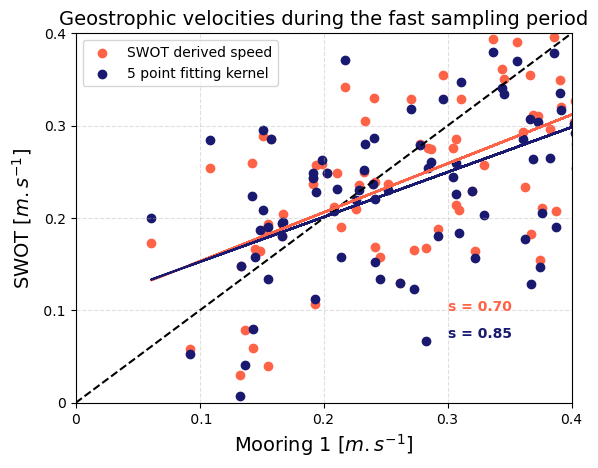

In [146]:
plt.scatter(u_mooring, u_swot, c='tomato', label='SWOT derived speed')

plt.scatter(u_mooring, u_fk, marker='o', c='midnightblue', label='5 point fitting kernel')

k,l = np.polyfit(u_mooring, u_swot, 1)
m, n = np.polyfit(u_mooring, u_fk, 1)

plt.yticks([0, 0.1, 0.2, 0.3, 0.4], ['0', ' 0.1', '0.2', '0.3', '0.4'])
plt.xticks([0, 0.1, 0.2, 0.3, 0.4], ['0', ' 0.1', '0.2', '0.3', '0.4'])

plt.plot([0, 0.1, 0.2, 0.3, 0.4], [0, 0.1, 0.2, 0.3, 0.4], c='k', linestyle='--')

plt.plot(u_mooring, k *u_mooring+l, c='tomato');
plt.plot(u_mooring, m *u_mooring+n, c='midnightblue');

plt.grid(linestyle='--',alpha=0.4)
plt.xlim(0, 0.4)
plt.ylim(0, 0.4)
plt.text(0.3, 0.1, "s = 0.70" , color='tomato', weight='bold')
plt.text(0.3, 0.07, "s = 0.85" , color='midnightblue', weight='bold')
plt.xlabel('Mooring 1 $[m.s^{-1}]$', fontsize=14)
plt.ylabel(r'SWOT $[m.s^{-1}]$', fontsize=14)
plt.title('Geostrophic velocities during the fast sampling period', fontsize=14)
plt.legend(loc = 'upper left')
# plt.savefig('scatter_plot_SWOT1_other.png', dpi=300);

In [148]:
m

0.4862500078084066

In [150]:
fitting_point = [10, 14, 18, 22, 26, 30, 34, 38]

RMSD = [0.07, 0.069, 0.067, 0.066, 0.065, 0.064,  0.063, 0.062]
corr = [0.539, 0.53, 0.515, 0.503, 0.488, 0.47, 0.456, 0.43]

corr_u = [0.772, 0.771, 0.767, 0.763, 0.756, 0.748, 0.738, 0.752]
RMSD_u = [0.076, 0.074, 0.073, 0.072, 0.071, 0.070, 0.070, 0.071]

corr_v = [0.540, 0.542, 0.543, 0.541, 0.535, 0.529, 0.521, 0.524]
RMSD_v = [0.0819, 0.0820, 0.0829, 0.0834, 0.0847, 0.0857, 0.0872, 0.0842]

corr_SWOT = [ 0.9740, 0.9786, 0.9822, 0.9833, 0.9807, 0.9761, 0.9684, 0.9554]
RMSD_SWOT = [0.0196, 0.0170, 0.01457, 0.0138, 0.01517, 0.0175, 0.0208, 0.0254]

corr_SWOT3 = [0.9484, 0.9510, 0.9518, 0.9469, 0.9398, 0.9257, 0.9073, 0.8714]
RMSD_SWOT3 = [0.0328, 0.0325, 0.0331, 0.0355, 0.0386, 0.0428, 0.0479, 0.0547]

corr_M3 = [0.9424, 0.9454, 0.9467, 0.9420, 0.9353, 0.9217, 0.9039, 0.8684]
RMSD_M3 = [0.0347,  0.0341, 0.0344, 0.0366, 0.0394, 0.0434, 0.0483, 0.0550]

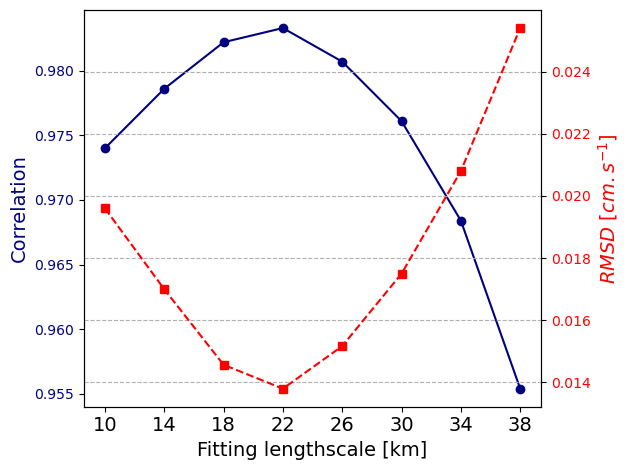

In [159]:
fig, ax1 = plt.subplots()

# Plot RMSD on left y-axis
color = 'navy'
ax1.set_xlabel('Fitting lengthscale [km]', fontsize=14)
ax1.set_xticks([10, 14, 18, 22, 26, 30, 34, 38], ['10', '14', '18', '22', '26','30','34', '38'], fontsize=14)
ax1.set_ylabel('Correlation', fontsize=14, color=color)
ax1.plot(fitting_point, corr_SWOT, marker='o', color=color, label='RMSD')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'red'
ax2.set_ylabel(r'$RMSD~[cm.s^{-1}]$', color=color, fontsize=14)
ax2.plot(fitting_point, RMSD_SWOT, marker='s', linestyle='--', color=color, label='Correlation')
ax2.tick_params(axis='y', labelcolor=color)


# plt.title('RMSD and Correlation vs fitting lengthscale')
fig.tight_layout()
plt.grid(True, linestyle='--')
plt.savefig('Figures/RMSD vs corr SWOT_ SWOT1.png', dpi=300);

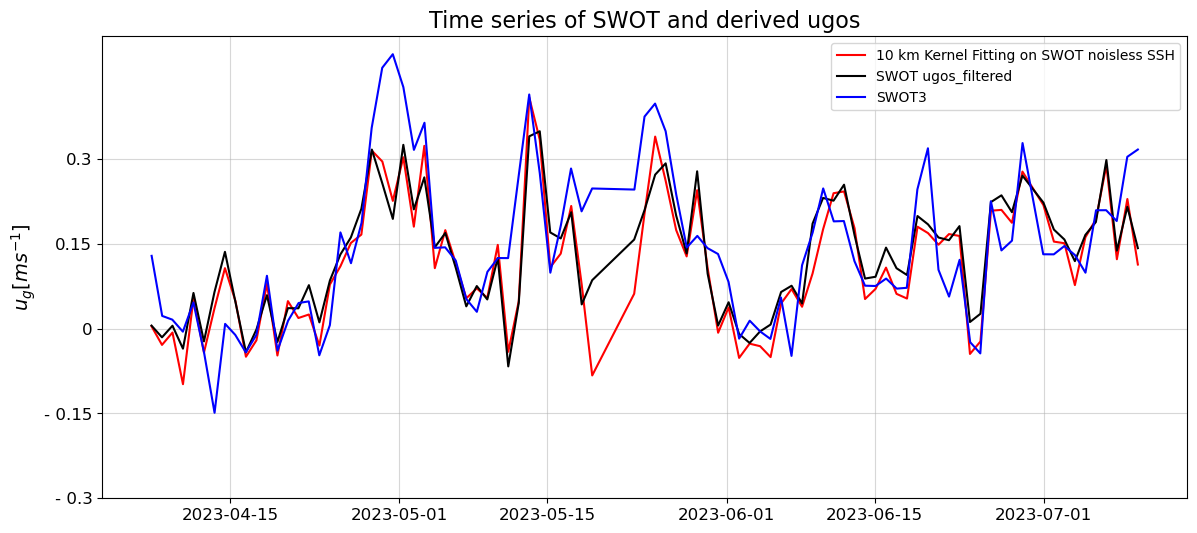

In [161]:
plt.figure(figsize=(14, 6))

plt.plot(df_swot_u.index, filtered_swot_u, c='r', label='10 km Kernel Fitting on SWOT noisless SSH')
# plt.plot(df_swot_ssha.index, df_swot_ssha['Value'], c='gray', label='ssha')

plt.plot(swot_data.time, swot_data.filtered_u, c='k', label='SWOT ugos_filtered')
plt.plot(dm_FS.TIME[time_indices], filtered_u_layer[time_indices], c='b', label= 'SWOT3')

plt.yticks([-0.3, -0.15, 0, 0.15, 0.3], ['- 0.3', '- 0.15', '0', '0.15', '0.3'])
plt.tick_params(axis='x', labelsize=12, colors='k')
plt.tick_params(axis='y', labelsize=12, colors='k')

# plt.xlabel('Time', fontsize=14)
plt.ylabel(r'$u_{g} [m s^{-1}]$', fontsize=14)
plt.title('Time series of SWOT and derived ugos', fontsize=16)
plt.grid(alpha=0.5)
plt.legend(loc='upper right')
# plt.savefig('SWOTcomparison_3.png', dpi=300);

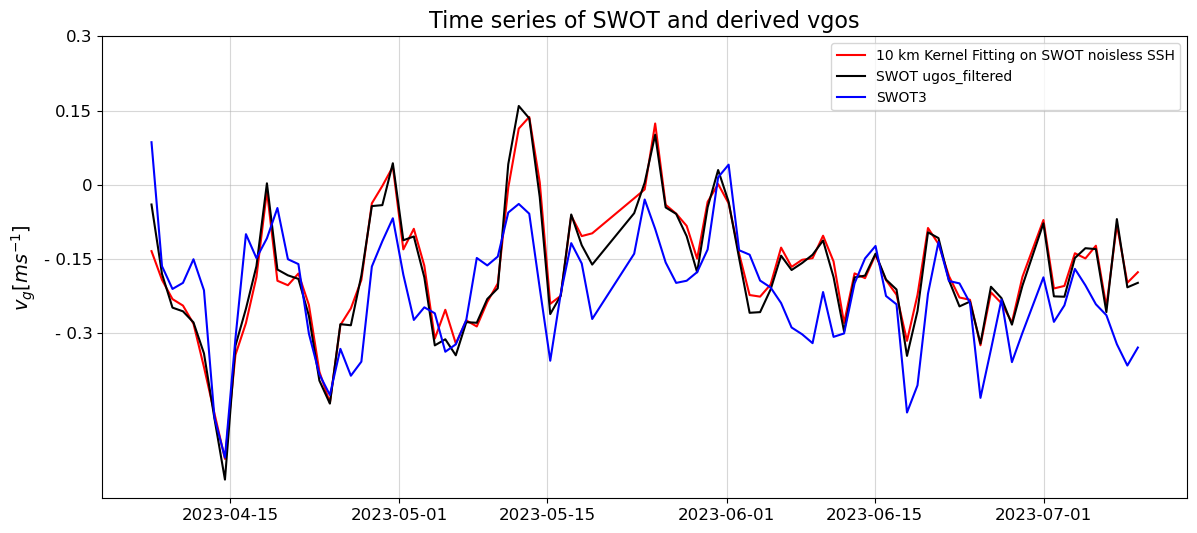

In [156]:
plt.figure(figsize=(14, 6))
# plt.plot(df_swot_v.index, df_interp_swot_v['Value'], c='r', label='10 km Kernel Fitting on SWOT noisless SSH')
plt.plot(df_swot_v.index, filtered_swot_v, c='r', label='10 km Kernel Fitting on SWOT noisless SSH')
plt.plot(swot_data.time, swot_data.filtered_v, c='k', label='SWOT ugos_filtered')
plt.plot(satellite_time, filtered_v_layer[time_indices], c='b', label= 'SWOT3')
plt.yticks([-0.3, -0.15, 0, 0.15, 0.3], ['- 0.3', '- 0.15', '0', '0.15', '0.3'])
plt.tick_params(axis='x', labelsize=12, colors='k')
plt.tick_params(axis='y', labelsize=12, colors='k')

# plt.xlabel('Time', fontsize=14)
plt.ylabel(r'$v_{g} [m s^{-1}]$', fontsize=14)
plt.title('Time series of SWOT and derived vgos', fontsize=16)
plt.grid(alpha=0.5)
plt.legend(loc='upper right')
# plt.savefig('SWOTcomparison_3_v.png', dpi=300);